In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
%matplotlib inline

## Predicting Car Prices

In [3]:
cars = pd.read_csv('imports-85.data')

In [4]:
cars.head()

,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


Rename columns to match specifications.

In [5]:
columns = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
          'num_doors', 'body_style', 'drive_wheels', 'engine_location',
          'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type',
          'num_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 
          'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
          'highway_mpg', 'price']

In [6]:
cars.columns = columns

In [7]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


Replace '?' with np.nan values to make dealing with missing values much easier. This allows use of nan finding methods.

In [8]:
cars.replace('?', np.nan, inplace=True)

Check the type of each column, we are only looking to use numerical columns. Some of the object columns cannot be easily converted, but we will convert the ones we can.

In [9]:
cars.dtypes

symboling              int64
normalized_losses     object
make                  object
fuel_type             object
aspiration            object
num_doors             object
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_cylinders         object
engine_size            int64
fuel_system           object
bore                  object
stroke                object
compression_ratio    float64
horsepower            object
peak_rpm              object
city_mpg               int64
highway_mpg            int64
price                 object
dtype: object

Let's convert the number of doors from a column of strings to a column of numbers.

In [10]:
cars.num_doors.unique()

array(['two', 'four', nan], dtype=object)

In [11]:
cars['num_doors'] = cars.num_doors.map({'two': 2, 'four':4})

In [12]:
cars.num_doors.unique()

array([  2.,   4.,  nan])

Let's update horsepower to a numeric columns as well.

In [16]:
cars['horsepower'] = pd.to_numeric(cars['horsepower'], errors='coerce')

In [17]:
cars.horsepower.dtype

dtype('float64')

In [18]:
cars[cars.normalized_losses.isnull()].shape[0] /cars.shape[0]

0.19607843137254902

So, almost 20% of the normalized_losses column is null, let's drop that column and then drop the rows with any null values.

In [19]:
cars.isnull().sum()

symboling             0
normalized_losses    40
make                  0
fuel_type             0
aspiration            0
num_doors             2
body_style            0
drive_wheels          0
engine_location       0
wheel_base            0
length                0
width                 0
height                0
curb_weight           0
engine_type           0
num_cylinders         0
engine_size           0
fuel_system           0
bore                  4
stroke                4
compression_ratio     0
horsepower            2
peak_rpm              2
city_mpg              0
highway_mpg           0
price                 4
dtype: int64

In [20]:
cars.shape[0]

204

In [21]:
cars.drop('normalized_losses', axis=1, inplace=True)

In [22]:
cars.dropna(axis=0, inplace=True)

In [23]:
cars.shape[0]

192

We only lost 12 rows by dropping null values accross the dataset.

In [24]:
cars['bore'] = pd.to_numeric(cars['bore'], errors='coerce')
cars['stroke'] = pd.to_numeric(cars['stroke'], errors='coerce')

Let's parse out our numeric columns from the original dataset so that we can normalize and start fitting a model.

In [25]:
cars_ml_cols = ['symboling', 'num_doors', 'wheel_base', 'length', 'width',
          'height', 'curb_weight', 'engine_size', 'bore', 'stroke',
          'compression_ratio', 'horsepower', 'city_mpg', 'highway_mpg']

In [26]:
cars_ml = cars[cars_ml_cols]

Normalize using the min/max formula, all values will now be between 0 and 1.

In [27]:
cars_ml = (cars_ml - cars_ml.min())/(cars_ml.max() - cars_ml.min())

In [28]:
cars_ml.head()

,symboling,num_doors,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,city_mpg,highway_mpg
0,1.0,0.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.12500,0.294393,0.222222,0.289474
1,0.6,0.0,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.12500,0.495327,0.166667,0.263158
2,0.8,1.0,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.18750,0.252336,0.305556,0.368421
3,0.8,1.0,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.06250,0.313084,0.138889,0.157895
4,0.8,0.0,0.384840,0.540299,0.512821,0.441667,0.395268,0.283019,0.464286,0.633333,0.09375,0.289720,0.166667,0.236842


We did not normalize the target column, let's add that to our model dataframe.

In [29]:
cars_ml['price'] = pd.to_numeric(cars['price'])

In [30]:
cars_ml.head()

,symboling,num_doors,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_ratio,horsepower,city_mpg,highway_mpg,price
0,1.0,0.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.12500,0.294393,0.222222,0.289474,16500
1,0.6,0.0,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.12500,0.495327,0.166667,0.263158,16500
2,0.8,1.0,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.18750,0.252336,0.305556,0.368421,13950
3,0.8,1.0,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.06250,0.313084,0.138889,0.157895,17450
4,0.8,0.0,0.384840,0.540299,0.512821,0.441667,0.395268,0.283019,0.464286,0.633333,0.09375,0.289720,0.166667,0.236842,15250


`knn_train_test` will use Scikit-Learn's `train_test_split` to split the the dataset, train a model and then use the predicted values to find the RMSE of the K-Nearest Neighbors model. 

In [31]:
def knn_train_test(features, target, data, k=5):
    if len(features) == 1:
        X = data[features].values.reshape(-1, 1)
    else:
        X = data[features]
    y =  data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.30, 
                                                        random_state=42)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    return rmse

Let's split out our non-target columns as features and then loop through them finding the RMSE for each and saving them in a dictionary.

In [32]:
features = [col for col in cars_ml.columns if col!= 'price']

In [33]:
uni_rmse = {}
for feature in features:
    uni_rmse[feature] = knn_train_test([feature], 'price', cars_ml)

In [34]:
uni_rmse

{'bore': 5657.0095289246974,
 'city_mpg': 3540.3205937043185,
 'compression_ratio': 5762.5621838517818,
 'curb_weight': 4205.9591403560762,
 'engine_size': 3273.9946613821194,
 'height': 8157.4794310244015,
 'highway_mpg': 4906.2293026666439,
 'horsepower': 4207.1392511563836,
 'length': 4523.4418758438724,
 'num_doors': 10176.855168808121,
 'stroke': 6639.3779086961722,
 'symboling': 8039.7257053484964,
 'wheel_base': 4886.0620916488851,
 'width': 4012.5605546617717}

All of the above models were fit with a $k$ equal to 5, what if we let $k$ be 1,3,5 or 7, how do the RMSEs change for each feature?

In [35]:
uni_rmse_k = {}
for feature in features:
    rmse_k = {}
    for k in [1,3,5,7]:
        rmse_k[k] = knn_train_test([feature], 'price', cars_ml, k=k)
    uni_rmse_k[feature] = rmse_k

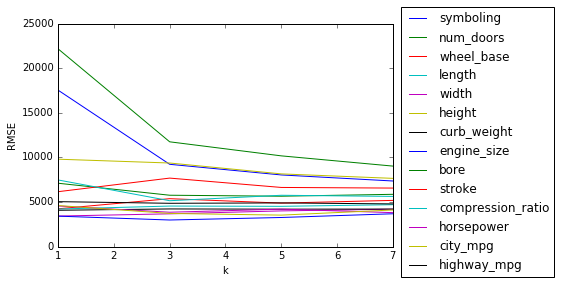

In [36]:
for feature in features:
    x = list(uni_rmse_k[feature].keys())
    y = list(uni_rmse_k[feature].values())
    plt.plot(x,y, label=feature);

plt.xlabel('k')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(1.5, 1.1));

It looks like $k=3$ results in the lowest RMSE for each column.

Let's run a multivariate knn model using a combination of the two-, three-, four- and five-best columns based on RMSE. I found this easier to do by creating a dataframe out of the dictionary.

In [38]:
rmse_df = pd.DataFrame.from_dict(uni_rmse, orient='index')

In [39]:
two_best = list(rmse_df.nsmallest(2, columns=0).index)
three_best = list(rmse_df.nsmallest(3, columns=0).index)
four_best = list(rmse_df.nsmallest(4, columns=0).index)
five_best = list(rmse_df.nsmallest(5, columns=0).index)

In [40]:
five_best

['engine_size', 'city_mpg', 'width', 'curb_weight', 'horsepower']

In [41]:
print('2 best RMSE: ', knn_train_test(two_best, 'price', cars_ml))
print('')
print('3 best RMSE: ', knn_train_test(three_best, 'price', cars_ml))
print('')
print('4 best RMSE: ', knn_train_test(four_best, 'price', cars_ml))
print('')
print('5 best RMSE: ', knn_train_test(five_best, 'price', cars_ml))

2 best RMSE:  3409.78552283

3 best RMSE:  3336.31231844

4 best RMSE:  2889.36093793

5 best RMSE:  2857.85271489


These RMSE values are already lower than any of the univariate results. Let's let $k$ range from 1-25 and see which results in the lowest RMSE.

In [42]:
ks = list(range(1, 26))

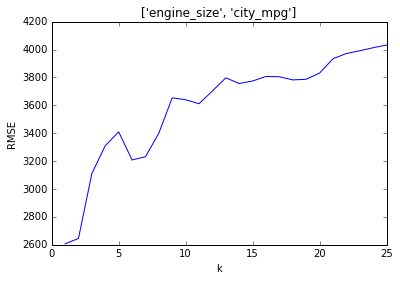

In [43]:
two_best_rmses = {}
for k in ks:
    two_best_rmses[k] = knn_train_test(two_best, 'price', cars_ml, k=k)

x = list(two_best_rmses.keys())
y = list(two_best_rmses.values())
plt.plot(x,y)
plt.title(two_best)
plt.xlabel('k')
plt.ylabel('RMSE');

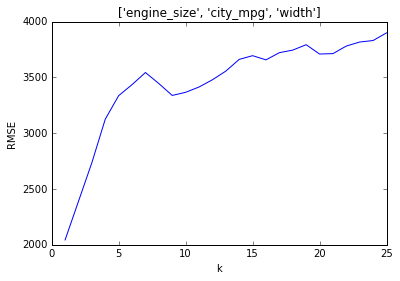

In [48]:
three_best_rmses = {}
for k in ks:
    three_best_rmses[k] = knn_train_test(three_best, 'price', cars_ml, k=k)

x = list(three_best_rmses.keys())
y = list(three_best_rmses.values())
plt.plot(x,y)
plt.title(three_best)
plt.xlabel('k')
plt.ylabel('RMSE');

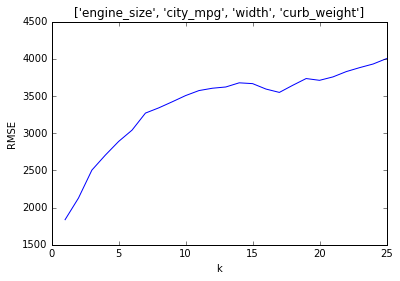

In [44]:
four_best_rmses = {}
for k in ks:
    four_best_rmses[k] = knn_train_test(four_best, 'price', cars_ml, k=k)

x = list(four_best_rmses.keys())
y = list(four_best_rmses.values())
plt.plot(x,y)
plt.title(four_best)
plt.xlabel('k')
plt.ylabel('RMSE');

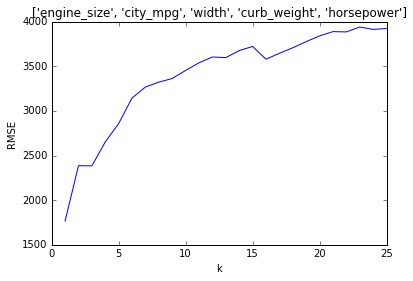

In [45]:
five_best_rmses = {}
for k in ks:
    five_best_rmses[k] = knn_train_test(five_best, 'price', cars_ml, k=k)

x = list(five_best_rmses.keys())
y = list(five_best_rmses.values())
plt.plot(x,y)
plt.title(five_best)
plt.xlabel('k')
plt.ylabel('RMSE');

In [49]:
print(min(two_best_rmses.values()))
print(min(three_best_rmses.values()))
print(min(four_best_rmses.values()))
print(min(five_best_rmses.values()))

2606.91847749
2043.75719339
1837.64621281
1765.51183845


The corresponding $k$ to the lowest RMSE was actually 1 for the five feature model. 

Finally, we can adapt the function above to use the k-fold method for splitting our data and training the model. Let's look at how the RMSE scores compare for the univariate models.

In [54]:
from sklearn.model_selection import cross_val_score, KFold

def knn_k_fold(features, target, data, k=5, folds = 3):
    if len(features) == 1:
        X = data[features].values.reshape(-1, 1)
    else:
        X = data[features]
    y =  data[target]

    kf = KFold(folds, shuffle = True, random_state = 1)
    knn = KNeighborsRegressor(n_neighbors=k)
    
    mses = cross_val_score(knn, X = X, y = y, 
                       scoring = 'neg_mean_squared_error',
                       cv = kf)
    avg_rmse = np.mean([np.sqrt(np.abs(x)) for x in mses])
    
    return avg_rmse

In [55]:
uni_rmse_kfold = {}
for feature in features:
    uni_rmse_kfold[feature] = knn_k_fold([feature], 'price', cars_ml)

In [53]:
uni_rmse_kfold

{'bore': 6780.5865249379958,
 'city_mpg': 3886.0703979077116,
 'compression_ratio': 6473.5795358729529,
 'curb_weight': 4406.939935037637,
 'engine_size': 3336.5419274636297,
 'height': 8089.0924008712054,
 'highway_mpg': 4170.8021014989945,
 'horsepower': 4239.8700666505711,
 'length': 5822.0802620878121,
 'num_doors': 9159.3599189772376,
 'stroke': 7543.3266993682118,
 'symboling': 9062.0192508509044,
 'wheel_base': 6296.6940461672339,
 'width': 4648.4532765547519}

In [47]:
uni_rmse_k_kfold = {}
for feature in features:
    rmse_k = {}
    for k in [1,3,5,7]:
        rmse_k[k] = knn_k_fold([feature], 'price', cars_ml, k=k)
    uni_rmse_k_kfold[feature] = rmse_k

In [48]:
uni_rmse_k_kfold

{'bore': {1: 6973.4190709079048,
  3: 6507.691265629509,
  5: 6780.5865249379958,
  7: 6720.8325386141305},
 'city_mpg': {1: 4843.7948850153316,
  3: 3947.9820818532535,
  5: 3886.0703979077116,
  7: 4288.341855990705},
 'compression_ratio': {1: 8025.6366270855797,
  3: 6968.1032982337611,
  5: 6473.5795358729529,
  7: 6765.7478105205846},
 'curb_weight': {1: 5175.7964811703214,
  3: 4472.5373059407038,
  5: 4406.939935037637,
  7: 4263.6109618282781},
 'engine_size': {1: 3581.7292743197845,
  3: 3138.2668683095017,
  5: 3336.5419274636297,
  7: 3451.8771756157671},
 'height': {1: 10140.090130248876,
  3: 8286.1522489655326,
  5: 8089.0924008712054,
  7: 8159.5545569394189},
 'highway_mpg': {1: 5623.0354501892652,
  3: 4496.9213818595426,
  5: 4170.8021014989945,
  7: 4435.6167586121301},
 'horsepower': {1: 4027.775963482236,
  3: 4083.4548026751258,
  5: 4239.8700666505711,
  7: 4417.5663600766211},
 'length': {1: 5187.9371224891256,
  3: 6067.9659193771886,
  5: 5822.0802620878121,
 